In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

RANDOM_STATE = 42
TARGET = 'price'

# Get the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

file_name = os.path.join(cwd, '..', 'data', 'raw', 'casas_dev.csv')
# Load the dataset
df = pd.read_csv(file_name)

import sys
sys.path.append(os.path.join(cwd, '..', 'src'))
from utils import convert_sqft_to_m2, plot_pairplot, feature_engineer
from data_splitting import train_validate_split, cross_validate, k_fold_split
from models import LinearRegression
from metrics import Metrics, MSE, MAE, R2
from preprocessing import one_hot_encoding, handle_missing_values, normalize_df

Current working directory: c:\Users\iluno\OneDrive\Documents\GitHub\ML\TP1\Nomberg_Ilan_TP1\notebooks


1.1

In [115]:
#split the dataset into train and validation
df_train, df_validate = train_validate_split(df, validation_size=0.2, random_state=RANDOM_STATE)

## Fill missing values
handle_missing_values(df_train, "age")
handle_missing_values(df_train, "rooms")

df_train_encoded = one_hot_encoding(df_train, "area_units")

convert_sqft_to_m2(df_train_encoded, "area_units_sqft", "area")

df_train_nomarlized, stats_dict_train = normalize_df(df_train_encoded, train=True)

handle_missing_values(df_validate, "age", train=False, stats=stats_dict_train)
handle_missing_values(df_validate, "rooms", train=False, stats=stats_dict_train)

df_validate_encoded = one_hot_encoding(df_validate, "area_units")

convert_sqft_to_m2(df_validate_encoded, "area_units_sqft", "area")

df_validate_nomarlized, _ = normalize_df(df_validate_encoded, train=False, stats=stats_dict_train)

# Save the modified dataset in the processed folder
file_name = os.path.join(cwd, '..', 'data', 'processed', 'casas_train.csv')
df_train_encoded.to_csv(file_name, index=False)

file_name = os.path.join(cwd, '..', 'data', 'processed', 'casas_val.csv')
df_validate_encoded.to_csv(file_name, index=False)

1.2

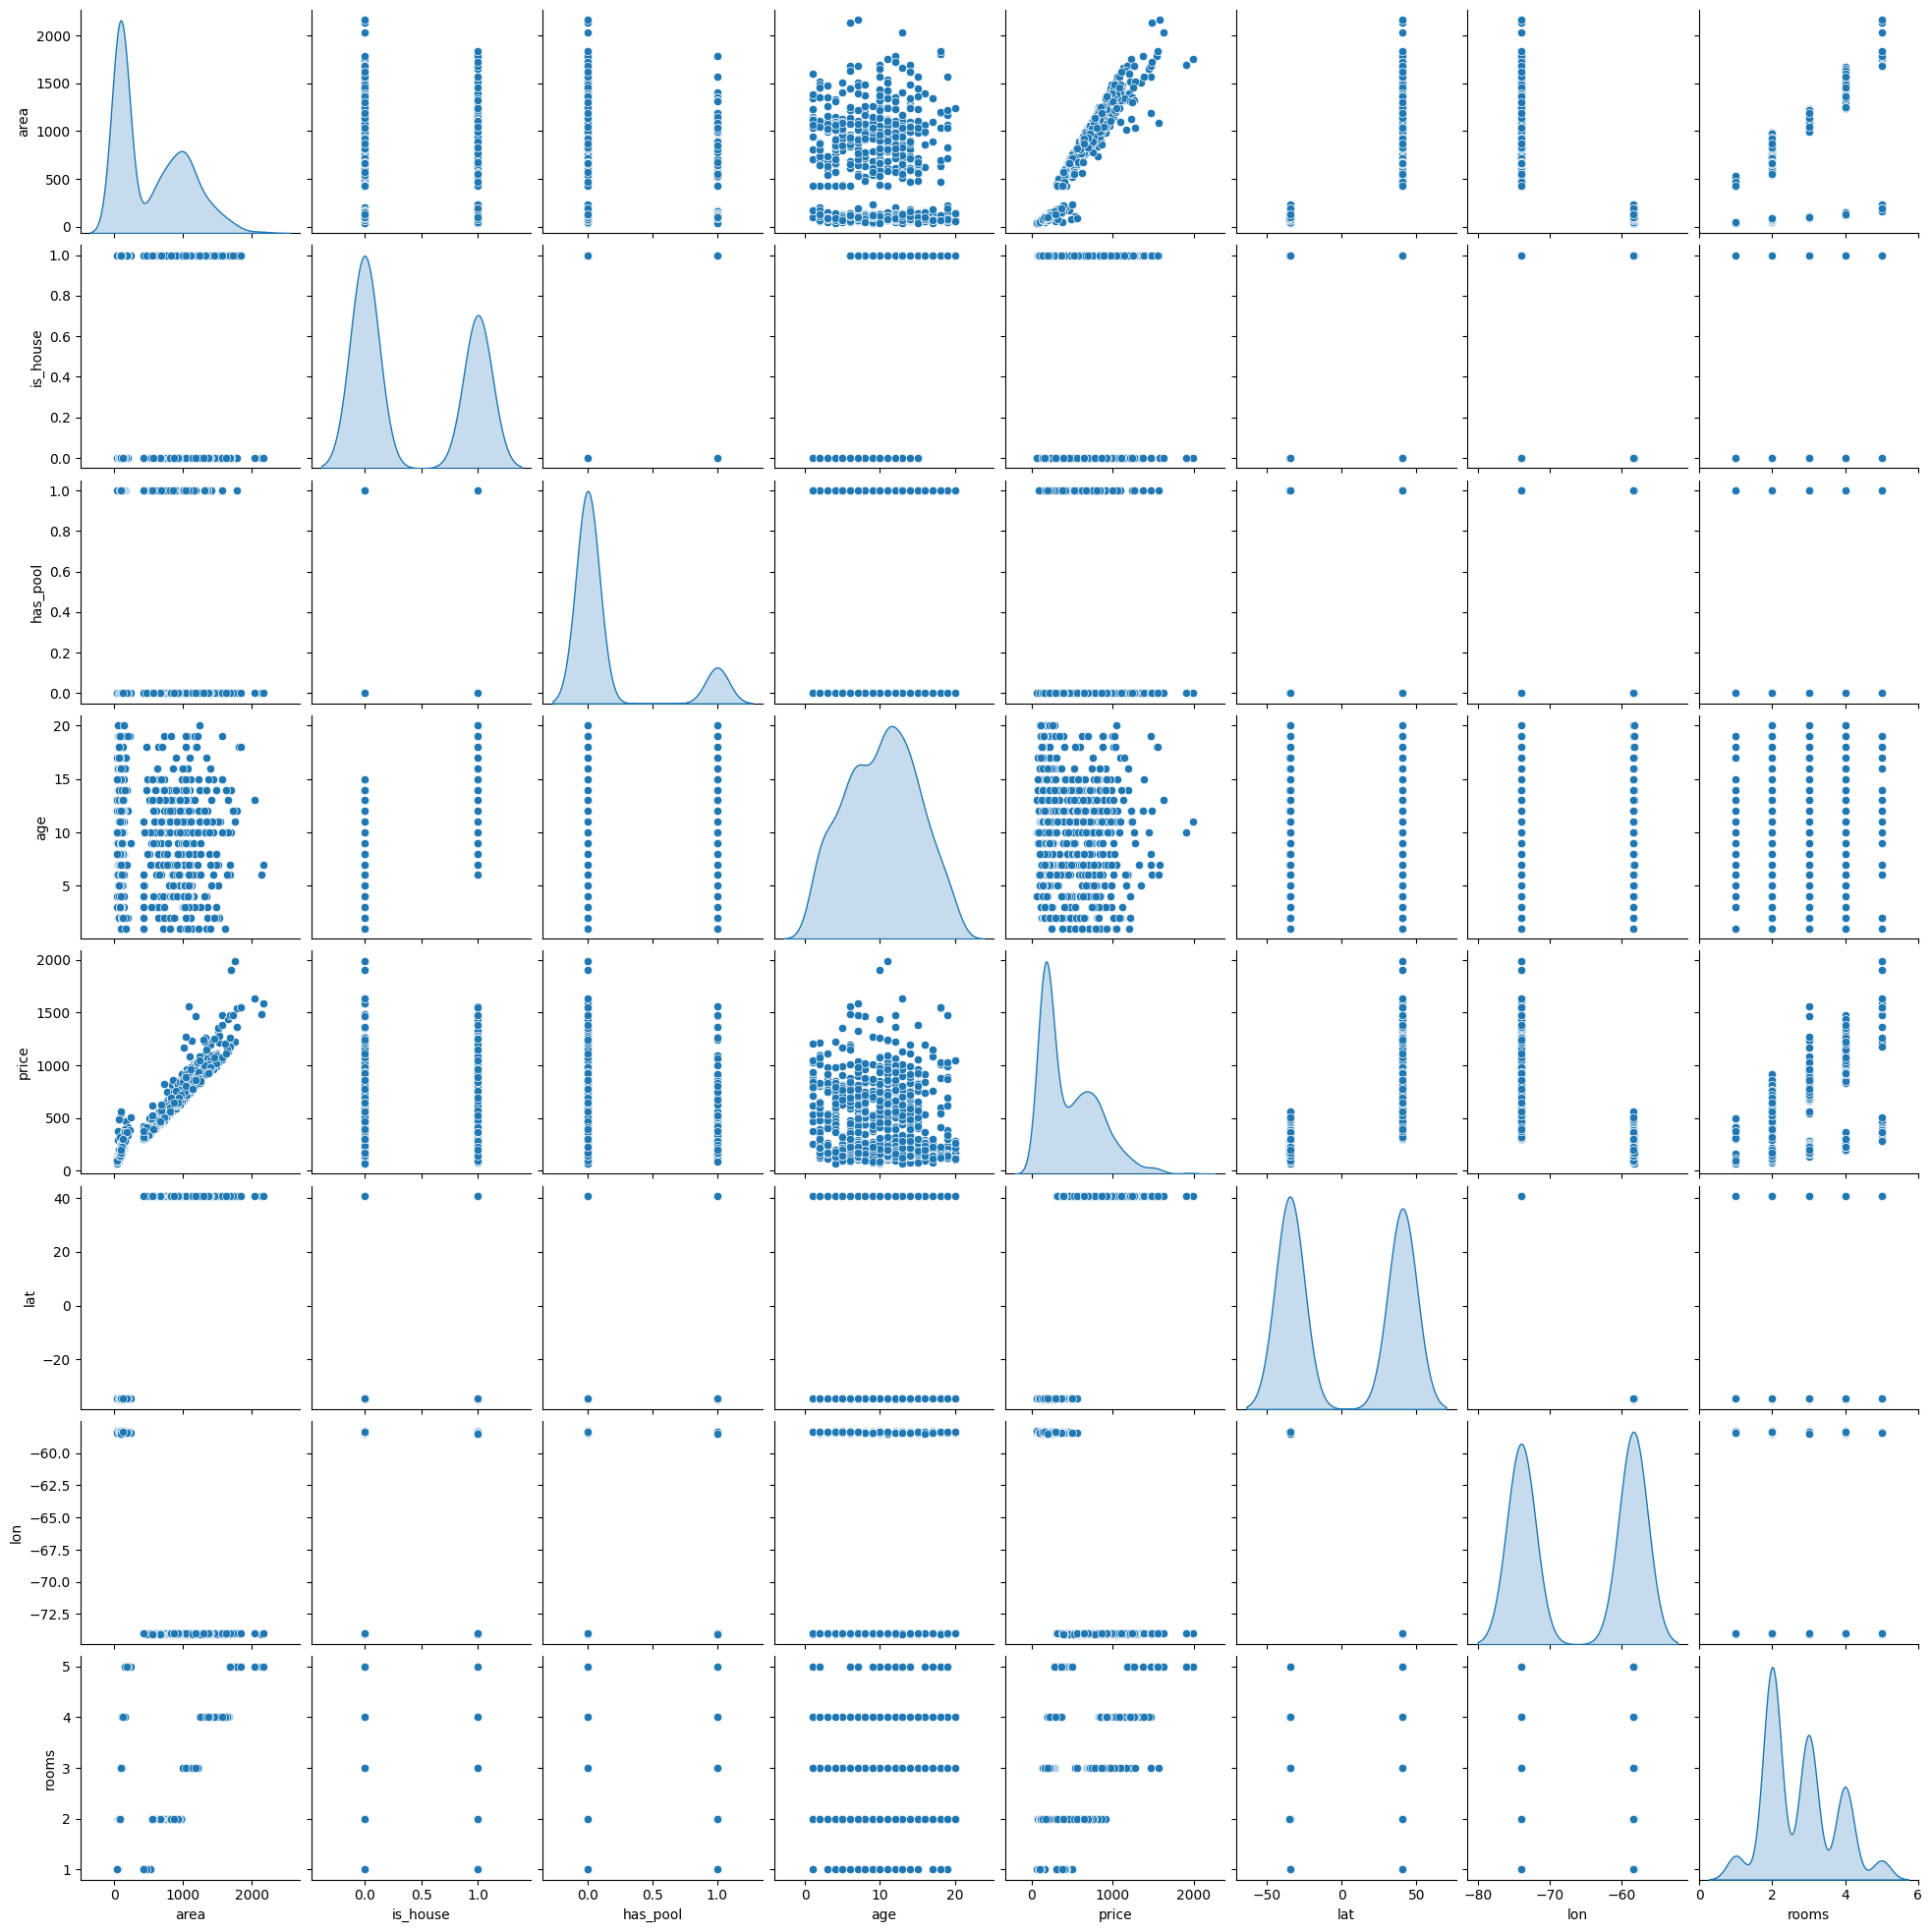

In [116]:
plot_pairplot(df)

2.3

In [117]:
features = df_train_nomarlized.columns.drop(TARGET)

X_train = df_train_nomarlized[features]
y_train = df_train_nomarlized[TARGET]

X_validate = df_validate_nomarlized[features]
y_validate = df_validate_nomarlized[TARGET]

model_pinv = LinearRegression(X_train, y_train)
model_gd = LinearRegression(X_train, y_train)

model_pinv.pinv_fit()
model_pinv.print_model()

model_gd.gradient_descent_fit()
model_gd.print_model()

mse = MSE()
mae = MAE()
r2 = R2()

mse_pinv = model_pinv.loss(X_validate, y_validate, mse)
mae_pinv = model_pinv.loss(X_validate, y_validate, mae)
r2_pinv = model_pinv.loss(X_validate, y_validate, r2)

mse_gd = model_gd.loss(X_validate, y_validate, mse)
mae_gd = model_gd.loss(X_validate, y_validate, mae)
r2_gd = model_gd.loss(X_validate, y_validate, r2)

print("MSE PINV:", mse_pinv)
print("MAE PINV:", mae_pinv)
print("R2 PINV:", r2_pinv)
print("")
print("MSE GD:", mse_gd)
print("MAE GD:", mae_gd)
print("R2 GD:", r2_gd)

**Trained using pinv method**


|   Intercept |     area |   is_house |   has_pool |        age |     lat |      lon |      rooms |   area_units_sqft |
|------------:|---------:|-----------:|-----------:|-----------:|--------:|---------:|-----------:|------------------:|
|     6.22558 | 0.463742 |   0.212152 |  0.0563772 | -0.0242112 | 8.12915 | 0.713064 | -0.0248828 |          -13.0447 |

**Trained using gradient_descent method**


|   Intercept |     area |   is_house |   has_pool |       age |     lat |      lon |      rooms |   area_units_sqft |
|------------:|---------:|-----------:|-----------:|----------:|--------:|---------:|-----------:|------------------:|
|  -0.0494165 | 0.450692 |    0.18521 |   0.113291 | -0.018031 | 1.08688 | 0.151714 | -0.0112864 |        -0.0910149 |

MSE PINV: 0.1318361791234782
MAE PINV: 0.25455308226902673
R2 PINV: 0.8584193754667622

MSE GD: 0.12747232150643045
MAE GD: 0.2513468846057358
R2 GD: 0.8631057801464448


3.1

In [118]:
# do the same with only the area column as a feature

X_train_area = X_train[['area']]
X_validate_area = X_validate[['area']]

model_pinv_area = LinearRegression(X_train_area, y_train)
model_gd_area = LinearRegression(X_train_area, y_train)

model_pinv_area.pinv_fit()
model_pinv_area.print_model()

model_gd_area.gradient_descent_fit()
model_gd_area.print_model()

mse_pinv_area = model_pinv_area.loss(X_validate_area, y_validate, mse)
mae_pinv_area = model_pinv_area.loss(X_validate_area, y_validate, mae)
r2_pinv_area = model_pinv_area.loss(X_validate_area, y_validate, r2)

mse_gd_area = model_gd_area.loss(X_validate_area, y_validate, mse)
mae_gd_area = model_gd_area.loss(X_validate_area, y_validate, mae)
r2_gd_area = model_gd_area.loss(X_validate_area, y_validate, r2)

print("MSE PINV AREA:", mse_pinv_area)
print("MAE PINV AREA:", mae_pinv_area)
print("R2 PINV AREA:", r2_pinv_area)
print("")
print("MSE GD AREA:", mse_gd_area)
print("MAE GD AREA:", mae_gd_area)
print("R2 GD AREA:", r2_gd_area)

**Trained using pinv method**


|   Intercept |     area |
|------------:|---------:|
| 7.97973e-17 | 0.391187 |

**Trained using gradient_descent method**


|   Intercept |     area |
|------------:|---------:|
|  1.8246e-05 | 0.391196 |

MSE PINV AREA: 0.8635038491651
MAE PINV AREA: 0.8537598394051402
R2 PINV AREA: 0.07267174257875841

MSE GD AREA: 0.8635062207601698
MAE GD AREA: 0.8537612095162064
R2 GD AREA: 0.07266919569130048


3.2

In [119]:
# estimate the price for vivienda_Amanda.csv

file_name = os.path.join(cwd, '..', 'data', 'raw', 'vivienda_Amanda.csv')
df_Amanda = pd.read_csv(file_name)

handle_missing_values(df_Amanda, "age")
handle_missing_values(df_Amanda, "rooms")

df_Amanda = one_hot_encoding(df_Amanda, "area_units")
convert_sqft_to_m2(df_Amanda, "area_units_sqft", "area")

df_Amanda_normalized, _ = normalize_df(df_Amanda, train=False, stats=stats_dict_train)

prediction_Amanda = model_pinv.predict(df_Amanda_normalized)

prediction_Amanda = prediction_Amanda * stats_dict_train['price']['std'] + stats_dict_train['price']['mean']

print("Prediction Amanda:", prediction_Amanda)


Prediction Amanda: [796.4671455]


3.3

In [120]:
# Filter the DataFrame to include only houses
df_houses = df_train_encoded[df_train_encoded['is_house'] == 1]

# Calculate the average price per m2 for the houses in the training dataset
price_per_m2 = df_houses['price'] / df_houses['area']

price_per_m2_mean = price_per_m2.mean()

print("Price per m2 mean for houses:", price_per_m2_mean)

Price per m2 mean for houses: 3.6536613907453885


3.4

Como el coeficiente para has_pool es positivo, podemos decir que la presencia de una pileta aumenta el precio de la casa. Ademas, para analizar la cantidad de plata que Benito puede gastar para construir la pileta, puede evaluar su casa en el modelo con y sin pileta, y ver cuanto aumenta el precio de la casa con la pileta.

4.1

In [ ]:
# feature engineering

df_train_FE = df_train_encoded.copy()
df_validate_FE = df_validate_encoded.copy()

df_train_FE = feature_engineer(df_train_FE)
df_validate_FE = feature_engineer(df_validate_FE)

df_train_nomarlized_FE, stats_dict_train_FE = normalize_df(df_train_FE, train=True)
df_validate_nomarlized_FE, _ = normalize_df(df_validate_FE, train=False, stats=stats_dict_train_FE)

features = df_train_nomarlized_FE.columns.drop(TARGET)

X_train_FE = df_train_nomarlized_FE[features]
y_train_FE = df_train_nomarlized_FE[TARGET]

X_validate_FE = df_validate_nomarlized_FE[features]
y_validate_FE = df_validate_nomarlized_FE[TARGET]

model_pinv = LinearRegression(X_train_FE, y_train_FE)
model_gd = LinearRegression(X_train_FE, y_train_FE)

model_pinv.pinv_fit()
model_pinv.print_model()

model_gd.gradient_descent_fit()
model_gd.print_model()

mse_pinv = model_pinv.loss(X_validate_FE, y_validate_FE, mse)
mae_pinv = model_pinv.loss(X_validate_FE, y_validate_FE, mae)
r2_pinv = model_pinv.loss(X_validate_FE, y_validate_FE, r2)

mse_gd = model_gd.loss(X_validate_FE, y_validate_FE, mse)
mae_gd = model_gd.loss(X_validate_FE, y_validate_FE, mae)
r2_gd = model_gd.loss(X_validate_FE, y_validate_FE, r2)

print("MSE PINV:", mse_pinv)
print("MAE PINV:", mae_pinv)
print("R2 PINV:", r2_pinv)
print("")
print("MSE GD:", mse_gd)
print("MAE GD:", mae_gd)
print("R2 GD:", r2_gd)


**Trained using pinv method**


|   Intercept |     area |   is_house |   has_pool |       age |     lat |     lon |    rooms |   area_units_sqft |   m2_per_room |    age_2 |   log_area |   log_rooms |   log_age |   distance_to_center_km |   rooms_age_interaction |   rooms_distance_interaction |   age_distance_interaction |   area_2 |   area_3 |   rooms_2 |   distance_to_center_2 |   rooms_per_m2 |   distance_per_age |    is_new |   is_big |   is_near_center |
|------------:|---------:|-----------:|-----------:|----------:|--------:|--------:|---------:|------------------:|--------------:|---------:|-----------:|------------:|----------:|------------------------:|------------------------:|-----------------------------:|---------------------------:|---------:|---------:|----------:|-----------------------:|---------------:|-------------------:|----------:|---------:|-----------------:|
|      8.9443 | -8.75654 |   0.317278 |  0.0764331 | -0.605868 | 13.0402 | 2.82052 | -2.16307 |          -18.6872 |      0.658635 | 0.305974 |    1.16905 |     3.96519 |  0.293354 |               -0.164047 |              0.00192167 |                    -0.459196 |                  0.0598883 |  9.14415 | -3.30238 |  0.731984 |                0.27669 |      -0.456154 |           0.110042 | -0.146186 | 0.106254 |        -0.129214 |

**Trained using gradient_descent method**


|   Intercept |     area |   is_house |   has_pool |       age |      lat |      lon |    rooms |   area_units_sqft |   m2_per_room |    age_2 |   log_area |   log_rooms |   log_age |   distance_to_center_km |   rooms_age_interaction |   rooms_distance_interaction |   age_distance_interaction |   area_2 |    area_3 |   rooms_2 |   distance_to_center_2 |   rooms_per_m2 |   distance_per_age |    is_new |      is_big |   is_near_center |
|------------:|---------:|-----------:|-----------:|----------:|---------:|---------:|---------:|------------------:|--------------:|---------:|-----------:|------------:|----------:|------------------------:|------------------------:|-----------------------------:|---------------------------:|---------:|----------:|----------:|-----------------------:|---------------:|-------------------:|----------:|------------:|-----------------:|
|   -0.316322 | 0.536291 |    0.30743 |  0.0759524 | -0.446227 | 0.806734 | 0.204985 | -0.31326 |          0.544438 |      0.061127 | 0.251634 |  -0.305206 |    0.529572 |  0.197591 |               -0.138371 |              -0.0086039 |                    -0.444658 |                  0.0209633 | 0.139486 | -0.232895 |  0.288505 |               0.288349 |     -0.0956058 |          0.0825008 | -0.153197 | -0.00566972 |        -0.131323 |

MSE PINV: 0.08331661759693622
MAE PINV: 0.21000753376229603
R2 PINV: 0.9105251772935334

MSE GD: 0.0812016695203267
MAE GD: 0.20778967417327615
R2 GD: 0.9127964481353658


4.3 

Esto genera features linealmente dependientes, esto hace que el modelo no generalice bien.

In [122]:
# randomly pick a feature and create a new feature that is a power of the original, do it 300 times\

df_train_powers = df_train_encoded.copy()
df_validate_powers = df_validate_encoded.copy()

# make a list of the features that are not the target and are not only 1s or 0s
features = df_train_powers.columns.drop([TARGET, 'is_house', 'has_pool', 'area_units_sqft'])

for i in range(300):
    power = np.random.randint(2, 20)
    feature = np.random.choice(features)
    new_feature = feature + "_{}".format(power)
    df_train_powers[new_feature] = df_train_powers[feature] ** power
    df_validate_powers[new_feature] = df_validate_powers[feature] ** power

df_train_nomarlized, stats_dict_train = normalize_df(df_train_powers, train=True)
df_validate_nomarlized, _ = normalize_df(df_validate_powers, train=False, stats=stats_dict_train)

features = df_train_nomarlized.columns.drop(TARGET)

X_train = df_train_nomarlized[features]
y_train = df_train_nomarlized[TARGET]

X_validate = df_validate_nomarlized[features]
y_validate = df_validate_nomarlized[TARGET]

model_pinv = LinearRegression(X_train, y_train)
model_gd = LinearRegression(X_train, y_train)

model_pinv.pinv_fit()
model_pinv.print_model()

model_gd.gradient_descent_fit()
model_gd.print_model()

mse_pinv = model_pinv.loss(X_validate, y_validate, mse)
mae_pinv = model_pinv.loss(X_validate, y_validate, mae)
r2_pinv = model_pinv.loss(X_validate, y_validate, r2)

mse_gd = model_gd.loss(X_validate, y_validate, mse)
mae_gd = model_gd.loss(X_validate, y_validate, mae)
r2_gd = model_gd.loss(X_validate, y_validate, r2)

mse_pinv_train = model_pinv.loss(X_train, y_train, mse)
mae_pinv_train = model_pinv.loss(X_train, y_train, mae)
r2_pinv_train = model_pinv.loss(X_train, y_train, r2)

print("MSE PINV TRAIN:", mse_pinv_train)
print("MAE PINV TRAIN:", mae_pinv_train)
print("R2 PINV TRAIN:", r2_pinv_train)
print("")
print("MSE PINV:", mse_pinv)
print("MAE PINV:", mae_pinv)
print("R2 PINV:", r2_pinv)
print("")
print("MSE GD:", mse_gd)
print("MAE GD:", mae_gd)
print("R2 GD:", r2_gd) 

**Trained using pinv method**


|   Intercept |    area |   is_house |   has_pool |     age |         lat |         lon |        rooms |   area_units_sqft |      lon_2 |    age_3 |      age_16 |     lon_10 |        lon_4 |     rooms_3 |      area_11 |      lon_11 |      area_17 |      rooms_7 |     rooms_12 |    rooms_11 |     rooms_16 |   rooms_17 |       lon_13 |       lon_6 |     rooms_19 |   area_6 |   area_5 |        lat_8 |       lat_12 |   age_15 |     rooms_4 |       lat_4 |   area_8 |       age_13 |       lat_11 |      rooms_9 |     area_10 |     rooms_8 |      lat_13 |   area_2 |      age_14 |       lon_5 |      lat_14 |   age_8 |       lat_18 |      age_18 |     area_15 |   lat_9 |      age_9 |   age_5 |   lon_14 |   lon_3 |   area_9 |   area_7 |   rooms_10 |       lon_9 |   rooms_15 |        lon_7 |   area_4 |       lon_12 |   area_14 |        lat_2 |   area_18 |   rooms_5 |   area_16 |   rooms_6 |        lon_8 |   lon_19 |   lon_18 |   lon_16 |   rooms_18 |   lat_3 |   lon_17 |        age_7 |       age_17 |   area_19 |       lon_15 |   age_12 |   age_2 |   lat_19 |     rooms_13 |      area_13 |        lat_6 |       age_6 |   rooms_14 |   age_11 |   lat_15 |        lat_5 |     area_12 |       age_10 |       lat_10 |   age_19 |   age_4 |   lat_17 |
|------------:|--------:|-----------:|-----------:|--------:|------------:|------------:|-------------:|------------------:|-----------:|---------:|------------:|-----------:|-------------:|------------:|-------------:|------------:|-------------:|-------------:|-------------:|------------:|-------------:|-----------:|-------------:|------------:|-------------:|---------:|---------:|-------------:|-------------:|---------:|------------:|------------:|---------:|-------------:|-------------:|-------------:|------------:|------------:|------------:|---------:|------------:|------------:|------------:|--------:|-------------:|------------:|------------:|--------:|-----------:|--------:|---------:|--------:|---------:|---------:|-----------:|------------:|-----------:|-------------:|---------:|-------------:|----------:|-------------:|----------:|----------:|----------:|----------:|-------------:|---------:|---------:|---------:|-----------:|--------:|---------:|-------------:|-------------:|----------:|-------------:|---------:|--------:|---------:|-------------:|-------------:|-------------:|------------:|-----------:|---------:|---------:|-------------:|------------:|-------------:|-------------:|---------:|--------:|---------:|
| 3.45964e+07 | -81.252 |   -213.516 |    15.0832 | -447.16 | 4.40344e+06 | 1.23474e+12 | -1.68388e+08 |      -7.13734e+07 | 2.8938e+12 | -53802.2 | 3.71074e+06 | -3.289e+11 | -3.26813e+12 | 9.49266e+08 | -1.45884e+06 | 1.64742e+11 | -1.02178e+06 | -1.07293e+10 | -1.81754e+11 | 1.59074e+11 | -2.19543e+11 | 3.9729e+11 | -1.43481e+11 | 1.95927e+12 | -1.45223e+11 | -65169.2 |    44997 | -2.54038e+06 | -1.39054e+06 |  -951751 | 1.29448e+08 | 3.90718e+06 |   508969 | -1.67003e+06 | -4.08018e+06 | -2.39559e+07 | 1.19429e+06 | 2.92057e+06 | 4.06277e+06 |  591.172 | 1.24545e+06 | 1.16628e+06 | 5.07059e+06 |   57194 | -1.64203e+06 | 3.70899e+06 | 1.88347e+06 |  492001 | 1.6234e+06 | -892643 |   316422 |  172462 |  -987400 |   -79517 |     414005 | 1.30462e+06 |    11820.4 | -1.72121e+06 | -11078.3 | -1.92715e+06 |   -669799 | -1.13258e+06 |    918719 |   -693154 |   -548648 |   96156.6 | -1.01833e+06 |   381584 |  -195972 |   180499 |    -154802 |  879255 |   552145 | -1.61635e+06 | -5.79497e+06 |   -231827 | -1.82777e+06 |   378970 | 5874.39 |   420919 | -1.25555e+06 | -1.45027e+06 | -1.04448e+06 | 1.68032e+06 |     847260 |   981760 |  -272322 | -1.09887e+06 | 1.97335e+06 | -1.82626e+06 | -1.30291e+06 |  -868595 |  282129 |  -925715 |

**Trained using gradient_descent method**


|   Intercept |     area |   is_house |   has_pool |       age |      lat |      lon |    rooms |   area_units_sqft |    lon_2 |    age_3 |   age_16 |    lon_10 |    lon_4 |   rooms_3 |    area_11 |   lon_11 |   area_17 |    rooms_7 |   rooms_12 |   rooms_11 |   rooms_16 |   rooms_17 |   lon_13 |     lon_6 |   rooms_19 |    area_6 |    area_5 |   lat_8 |   lat_12 |    age_15 |   rooms_4 |      lat_4 |    area_8 |   age_13 |    lat_11 |   rooms_9 |   area_10 |   rooms_8 |   lat_13 |    area_2 |   age_14 |    lon_5 |    lat_14 |      age_8 |   lat_18 |    age_18 |   area_15 |     lat_9 |       age_9 |     age_5 |   lon_14 |    lon_3 |   area_9 |   area_7 |   rooms_10 |    lon_9 |   rooms_15 |    lon_7 |   area_4 |   lon_12 |   area_14 |    lat_2 |   area_18 |   rooms_5 |   area_16 |    rooms_6 |    lon_8 |   lon_19 |   lon_18 |     lon_16 |   rooms_18 |     lat_3 |   lon_17 |    age_7 |    age_17 |   area_19 |   lon_15 |    age_12 |     age_2 |   lat_19 |   rooms_13 |    area_13 |    lat_6 |    age_6 |   rooms_14 |    age_11 |   lat_15 |     lat_5 |   area_12 |   age_10 |   lat_10 |    age_19 |     age_4 |   lat_17 |
|------------:|---------:|-----------:|-----------:|----------:|---------:|---------:|---------:|------------------:|---------:|---------:|---------:|----------:|---------:|----------:|-----------:|---------:|----------:|-----------:|-----------:|-----------:|-----------:|-----------:|---------:|----------:|-----------:|----------:|----------:|--------:|---------:|----------:|----------:|-----------:|----------:|---------:|----------:|----------:|----------:|----------:|---------:|----------:|---------:|---------:|----------:|-----------:|---------:|----------:|----------:|----------:|------------:|----------:|---------:|---------:|---------:|---------:|-----------:|---------:|-----------:|---------:|---------:|---------:|----------:|---------:|----------:|----------:|----------:|-----------:|---------:|---------:|---------:|-----------:|-----------:|----------:|---------:|---------:|----------:|----------:|---------:|----------:|----------:|---------:|-----------:|-----------:|---------:|---------:|-----------:|----------:|---------:|----------:|----------:|---------:|---------:|----------:|----------:|---------:|
|    -0.12912 | 0.547189 |   0.327697 |   0.205099 | -0.156346 | 0.746993 | 0.984999 | 0.108588 |        -0.0927042 | 0.487269 | 0.406829 | 0.215327 | -0.208423 | -0.19292 | -0.174059 | -0.0628708 | 0.820008 |  0.269019 | -0.0927274 |   0.118381 |   0.113846 |   0.346503 |   -0.32415 | 0.693698 | 0.0408217 |  -0.407149 | -0.392118 | -0.364647 | 0.16926 | 0.622709 | 0.0162227 | -0.160706 | -0.0343938 | -0.376636 | 0.251005 | 0.0840415 | -0.524351 |  0.164436 |  0.276683 | 0.145178 | -0.188907 | 0.246965 | 0.756592 | 0.0271095 | 0.00604101 | 0.633234 | 0.0264372 | -0.297635 | 0.0327361 | -0.00415879 | -0.405067 |   0.3619 | 0.224407 |  0.51135 | 0.140892 |  -0.198494 | 0.466807 |  -0.177759 | 0.849564 | 0.462792 | 0.604827 | -0.190664 | 0.352585 | -0.166768 |   0.42164 |  0.104661 | -0.0852624 | 0.486877 | 0.450822 |   0.4659 | -0.0404251 |   0.419431 | -0.175658 | 0.249235 | 0.119904 | -0.173383 | -0.277743 | 0.449359 | -0.153569 | 0.0197991 |   0.2414 |   0.276047 | 0.00800597 | 0.642807 | 0.155453 |   0.153841 | -0.451623 | 0.110181 | -0.109693 |  0.462022 | 0.196024 | 0.775107 | -0.185359 | -0.184977 | 0.640226 |

MSE PINV TRAIN: 1142603.9699113946
MAE PINV TRAIN: 806.7975724428019
R2 PINV TRAIN: -1144192.127032273

MSE PINV: 1127076.8815904756
MAE PINV: 770.2337021424552
R2 PINV: -1210381.8391681304

MSE GD: 0.1252093946612517
MAE GD: 0.24678624925100553
R2 GD: 0.8655359673541108


5.2

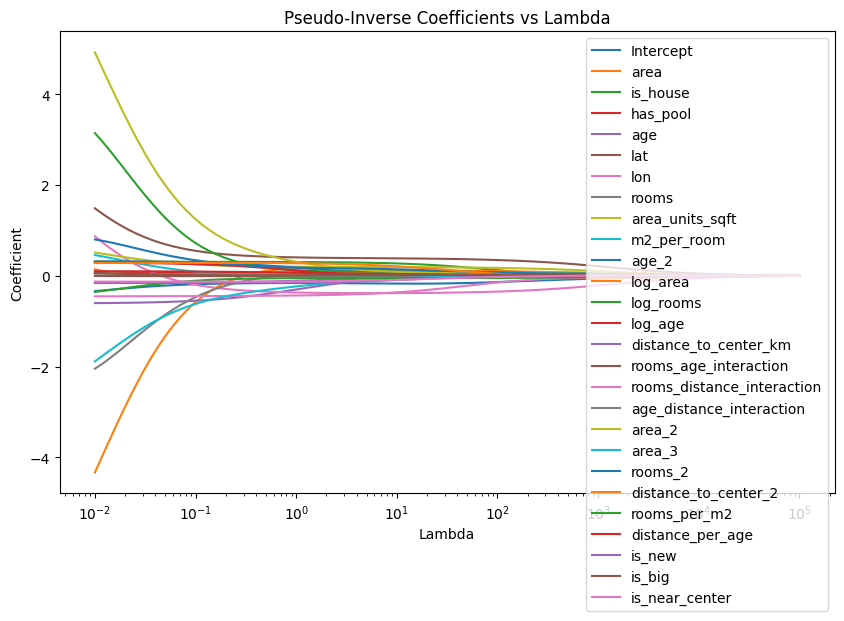

In [ ]:
# make a plot of the coefficients of the features vs the lambda of L2 regularization using pseudo-inverse

lambdas_pinv = np.logspace(-2, 5, 100)
coefficients_pinv = []

for l in lambdas_pinv:
    model = LinearRegression(X_train_FE, y_train_FE, L2=l)
    model.pinv_fit()
    coef_with_intercept = np.concatenate(([model.intercept_], model.coef_))
    coefficients_pinv.append(coef_with_intercept)

coefficients_pinv = np.array(coefficients_pinv)

# Include the intercept term in the features list
features = X_train_FE.columns
features_with_intercept = ['Intercept'] + list(features)

plt.figure(figsize=(10, 6))
for i in range(coefficients_pinv.shape[1]):
    plt.plot(lambdas_pinv, coefficients_pinv[:, i], label=features_with_intercept[i])

plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficient')
plt.legend(loc='upper right')
plt.title('Pseudo-Inverse Coefficients vs Lambda')
plt.show()

# make a plot of the coefficients of the features vs the lambda of L2 regularization using gradient descent

lambdas_gd = np.logspace(-2, 2, 100)
coefficients_gd = []

for l in lambdas_gd:
    model = LinearRegression(X_train_FE, y_train_FE, L2=l)
    model.gradient_descent_fit()
    coef_with_intercept = np.concatenate(([model.intercept_], model.coef_))
    coefficients_gd.append(coef_with_intercept)

coefficients_gd = np.array(coefficients_gd)

plt.figure(figsize=(10, 6))
for i in range(coefficients_gd.shape[1]):
    plt.plot(lambdas_gd, coefficients_gd[:, i], label=features_with_intercept[i])

plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficient')
plt.legend(loc='upper right')
plt.title('Gradient Descent Coefficients vs Lambda')
plt.show()

5.3

In [ ]:
## do the same with L1 regularization
lambdas_gd = np.logspace(-2, 1, 100)
coefficients = []

for l in lambdas_gd:
    model = LinearRegression(X_train_FE, y_train_FE, L1=l)
    model.gradient_descent_fit()
    coef_with_intercept = np.concatenate(([model.intercept_], model.coef_))
    coefficients.append(coef_with_intercept)

coefficients = np.array(coefficients)

plt.figure(figsize=(10, 6))
for i in range(coefficients.shape[1]):
    plt.plot(lambdas_gd, coefficients[:, i], label=features_with_intercept[i])

plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficient')
plt.legend(loc='upper left')
plt.show()


KeyboardInterrupt: 

NO SE QUE PONER EN EL 5.4

5.5 no mejora

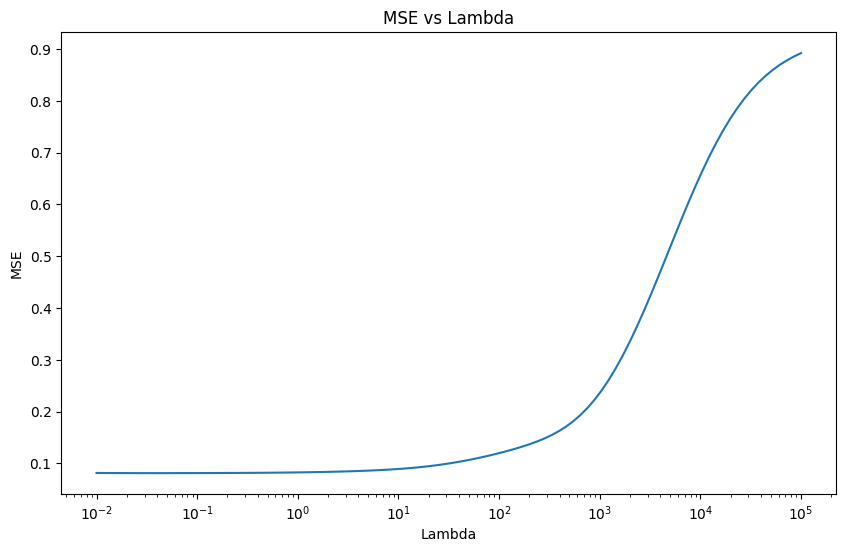

In [ ]:
#test for the lambda that gives the best MSE on the validation set
lambdas = np.logspace(-2, 5, 100)
mse_values = []

for l in lambdas:
    model = LinearRegression(X_train_FE, y_train_FE, L2=l)
    model.pinv_fit()
    mse_values.append(model.loss(X_validate_FE, y_validate_FE, mse))

plt.figure(figsize=(10, 6))
plt.plot(lambdas, mse_values)
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('MSE vs Lambda')
plt.show()



5.6

c:\Users\iluno\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


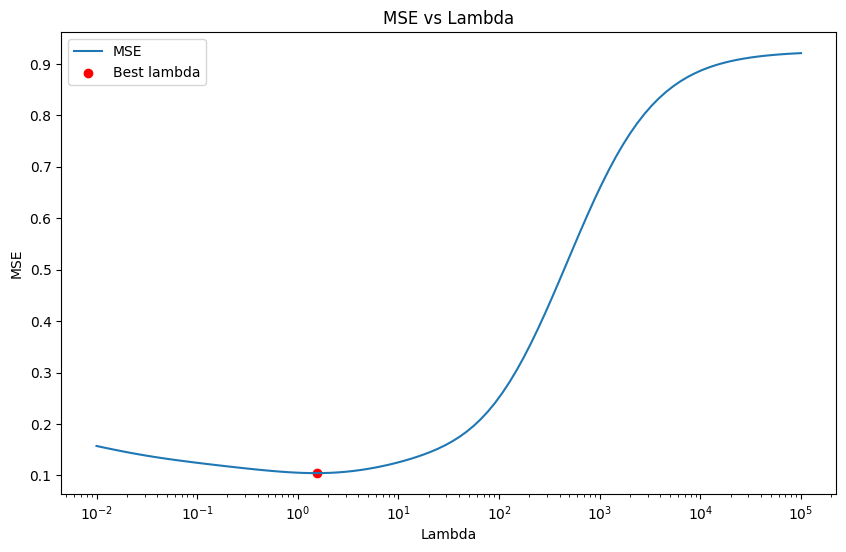

Best lambda: 1.5556761439304723


In [ ]:
# use cross validation to find the best lambda for L2 regularization
lambdas = np.logspace(-2, 5, 100)

best_lambda, errors = cross_validate(df_train_nomarlized_FE, df_validate_nomarlized_FE, lambdas=lambdas, L2=True)

# plot the lambdas and the errors

plt.figure(figsize=(10, 6))
plt.plot(lambdas, errors, label='MSE')
plt.scatter(best_lambda, min(errors), color='red', label='Best lambda')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.title('MSE vs Lambda')
plt.legend()
plt.show()


print("Best lambda:", best_lambda)

6.1

cross validated FE

6.2

In [ ]:
# compute the MSE, MAE and R2 for the test set using the best lambda

model = LinearRegression(X_train_FE, y_train_FE, L2=best_lambda)
model.pinv_fit()

df_test = pd.read_csv(os.path.join(cwd, '..', 'data', 'raw', 'casas_test.csv'))

handle_missing_values(df_test, "age")
handle_missing_values(df_test, "rooms")

df_test = one_hot_encoding(df_test, "area_units")
convert_sqft_to_m2(df_test, "area_units_sqft", "area")

df_test = feature_engineer(df_test)

df_test_normalized, _ = normalize_df(df_test, train=False, stats=stats_dict_train_FE)

features = df_train_nomarlized_FE.columns.drop(TARGET)

X_test = df_test_normalized[features]
y_test = df_test_normalized[TARGET]

mse_test = model.loss(X_test, y_test, mse)
mae_test = model.loss(X_test, y_test, mae)
r2_test = model.loss(X_test, y_test, r2)

print("MSE test:", mse_test)
print("MAE test:", mae_test)
print("R2 test:", r2_test)

MSE test: 0.06626794309491027
MAE test: 0.20178149282799895
R2 test: 0.9139471654778001
